<a href="https://colab.research.google.com/github/SyedAnasAli3/Masters-course-ML-projects/blob/main/RNN_using_LSTM_layers_for_sentiment_analysis_and_time_series_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recurrent neural networks

The goal is to learn to use LSTM layers in keras for sentiment analysis and time series prediction. 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

## Sentiment analysis

The goal to use recurrent neural networks (LSTM) to perform **sentiment analysis** on short sentences, i.e. to predict whether the sentence has a positive or negative meaning.

The following cells represent your training and test data. They are lists of lists, where the first element is the sentence as a string, and the second a boolean, with `True` for positive sentences, `False` for negative ones.

Notice how some sentences are ambiguous (if you do not notice the "not", the sentiment might be very different).

In [ ]:
train_data = [
  ['good', True],
  ['bad', False],
  ['happy', True],
  ['sad', False],
  ['not good', False],
  ['not bad', True],
  ['not happy', False],
  ['not sad', True],
  ['very good', True],
  ['very bad', False],
  ['very happy', True],
  ['very sad', False],
  ['i am happy', True],
  ['this is good', True],
  ['i am bad', False],
  ['this is bad', False],
  ['i am sad', False],
  ['this is sad', False],
  ['i am not happy', False],
  ['this is not good', False],
  ['i am not bad', True],
  ['this is not sad', True],
  ['i am very happy', True],
  ['this is very good', True],
  ['i am very bad', False],
  ['this is very sad', False],
  ['this is very happy', True],
  ['i am good not bad', True],
  ['this is good not bad', True],
  ['i am bad not good', False],
  ['i am good and happy', True],
  ['this is not good and not happy', False],
  ['i am not at all good', False],
  ['i am not at all bad', True],
  ['i am not at all happy', False],
  ['this is not at all sad', True],
  ['this is not at all happy', False],
  ['i am good right now', True],
  ['i am bad right now', False],
  ['this is bad right now', False],
  ['i am sad right now', False],
  ['i was good earlier', True],
  ['i was happy earlier', True],
  ['i was bad earlier', False],
  ['i was sad earlier', False],
  ['i am very bad right now', False],
  ['this is very good right now', True],
  ['this is very sad right now', False],
  ['this was bad earlier', False],
  ['this was very good earlier', True],
  ['this was very bad earlier', False],
  ['this was very happy earlier', True],
  ['this was very sad earlier', False],
  ['i was good and not bad earlier', True],
  ['i was not good and not happy earlier', False],
  ['i am not at all bad or sad right now', True],
  ['i am not at all good or happy right now', False],
  ['this was not happy and not good earlier', False],
]

In [ ]:
test_data = [
  ['this is happy', True],
  ['i am good', True],
  ['this is not happy', False],
  ['i am not good', False],
  ['this is not bad', True],
  ['i am not sad', True],
  ['i am very good', True],
  ['this is very bad', False],
  ['i am very sad', False],
  ['this is bad not good', False],
  ['this is good and happy', True],
  ['i am not good and not happy', False],
  ['i am not at all sad', True],
  ['this is not at all good', False],
  ['this is not at all bad', True],
  ['this is good right now', True],
  ['this is sad right now', False],
  ['this is very bad right now', False],
  ['this was good earlier', True],
  ['i was not happy and not good earlier', False],
  ['earlier i was good and not bad', True],
]

In [ ]:
N_train = len(train_data)
N_test = len(test_data)
print(N_train, "training sentences.")
print(N_test, "test sentences.")

58 training sentences.
21 test sentences.


### Data preparation

The most boring part when training LSTMs on text is to prepare the data correctly. Sentences are sequences of words (possibly a huge number of words), with a variable length (some sentences are shorter than others).

What neural networks expect as input is a fixed-length sequence of numerical vectors $\{\mathbf{x}_t\}_{t=0}^T$, i.e. they must have a fixed size. So we need to transform each sentence into this format.

The first thing to do is to identify the vocabulary, i.e. the **unique** words in the training set (fortunately, the test set uses the same exact words) as well as the maximal number of words in each sentence (again, the test set does not have longer sentences).

**Q:** Create a list `vocabulary` of unique words in the training set and compute the maximal length `nb_words` of a sentence.

To extract the words in each sentence, the `split()` method of Python strings might come handy:

```python
sentence = "I fear this exercise will be difficult"
print(sentence.split(" "))
```

You will also find the `set` Python object useful to identify unique works. Check the doc. But there are many ways to do that (for loops), just do it the way you prefer.

In [ ]:
vocabulary = list(set([w for pair in train_data for w in pair[0].split(' ')]))
print('Unique words found', len(vocabulary)) # 18 unique words found

nb_words = np.max([len(pair[0].split(' ')) for pair in train_data])
print("Maximum sequence length:", nb_words)

Unique words found 18
Maximum sequence length: 10


Now that we have found our list of 18 unique words, we need to able to perform **one-hot encoding** of each word, i.e. write a method `def one_hot_encoding(word, vocabulary)` that takes a word (e.g. "good") and the vocabulary, and returns a vector of size 18, with mostly zeros, except for a `1.0` at the location of the word in the vocabulary.

For example, if your vocabulary is `["I", "love", "you"]`, the one-hot encoding of "I" should be `np.array([1., 0., 0.])`, the one of "love" is `np.array([0., 1., 0.])`, etc.

**Q:** Implement the `one_hot_encoding()` method for single words.

*Hint:* you might find the method `index()` of list objects interesting.

In [ ]:
def one_hot_encoding(word, vocabulary):
    r = np.zeros(len(vocabulary))
    r[vocabulary.index(word)] = 1.0
    return r

**Q:** You can now create the training set `X_train, T_train` and the test set `X_test, T_test`.

The training input data `X_train` should be a numpy array with 3 dimensions:

```python
 X_train = np.zeros((N_train, nb_words, len(vocabulary)))
```

The first index corresponds to each sentence. The second index represents the index of each word in the sentence (maximally `nb_words=10`). The third index is for the one-hot encoding (18 elements).

**Beware:** most sentences are shorter than `nb_words=10`. In that case, the words should be set **at the end of the sequence**, i.e. you prepend zero vectors. 

For example, "I love you" should be encoded as:

```python
"", "", "", "", "", "", "", "I", "love", "you"
```

not as:

```python
"I", "love", "you", "", "", "", "", "", "", ""
```

The reason for that is that the LSTM will get the words one by one and only respond "positive" or "negative" after the last word has been seen. If the words are provided at the beginning of the sequence, vanishing gradients might delete them.

The same holds for the test set, it only has less sentences.

In [ ]:
def prepare_data(data, vocabulary, nb_words):
    
    N = len(data)
    X = np.zeros((N, nb_words, len(vocabulary)))
    T = np.zeros((N, ))
    
    # Iterate over the data
    for i in range(N):
        x, t = data[i]
        # Transform the sentence
        words = x.split(" ")
        for j in range(len(words)):
            word = words[j]
            encoding = one_hot_encoding(word, vocabulary)
            X[i, -len(words) + j, :] = encoding
        # Transform the output
        T[i] = int(t)
    return X, T

In [ ]:
X_train, T_train = prepare_data(train_data, vocabulary, nb_words)
X_test, T_test = prepare_data(test_data, vocabulary, nb_words)
print(X_train.shape)
print(T_train.shape)
print(X_test.shape)
print(T_test.shape)

(58, 10, 18)
(58,)
(21, 10, 18)
(21,)


### Training the LSTM

Now we just have to provide the data to a recurrent network. The problem is not very complicated, so we will need a single LSTM layer, followed by a single output neuron (with the logistic transfer function) whose role is to output 1 for the positive class, 0 for the negative one.

**Q:** Check the documentation for the LSTM layer of `keras`: <https://keras.io/api/layers/recurrent_layers/lstm/>. It has many parameters:

```python
tf.keras.layers.LSTM(
    units, 
    activation='tanh', 
    recurrent_activation='sigmoid', 
    use_bias=True, 
    kernel_initializer='glorot_uniform', 
    recurrent_initializer='orthogonal', 
    bias_initializer='zeros', 
    unit_forget_bias=True, 
    kernel_regularizer=None, 
    recurrent_regularizer=None, bias_regularizer=None, 
    activity_regularizer=None, kernel_constraint=None, 
    recurrent_constraint=None, bias_constraint=None, 
    dropout=0.0, recurrent_dropout=0.0, 
    implementation=2, 
    return_sequences=False, return_state=False, 
    go_backwards=False, stateful=False, unroll=False)
```

The default value for the parameters is the vanilla LSTM seen in the lectures, but you have the possibility to change the activation functions for the inputs and outputs (not the gates, it must be a sigmoid!), initialize the weights differently, add regularization or dropout, use biases or not, etc. That's a lot to play with. For this exercise, stick to the default parameters at the beginning. The only thing you need to define is the number of neurons `units` of the layer. 

```python
tf.keras.layers.LSTM(units=N)
```

Note that an important parameter is `return_sequences`. When set to False (the default), the LSTM layer will process the complete sequence of 10 word vectors, and output a single vector of $N$ values (the number of units). When set to True, the layer would return a sequence of 10 vectors of size $N$.

Here, we only want the LSTM layer to encode the sentence and feed a single vector to the output layer, so we can leave it to False. If we wanted to stack two LSTM layers on top of each other, we would need to set `return_sequences` to True for the first layer and False for the second one (you can try that later):

```python
tf.keras.layers.LSTM(N, return_sequences=True)
tf.keras.layers.LSTM(M, return_sequences=False)
```

**Q:** Create a model with one LSTM layer (with enough units) and one output layer with one neuron (`'sigmoid'` activation function). Choose an optimizer (SGD, RMSprop, Adam, etc) and a good learning rate. When compiling the model, use the `'binary_crossentropy'` loss function as it is a binary classification.

The input layer of the network must take a `(nb_words, len(vocabulary))` matrix as input, i.e. (window, nb_features).

```python
tf.keras.layers.Input((nb_words, len(vocabulary)))
```

When training the model with `model.fit()`, you can pass the test set as validation data, as we do not have too many examples:

```python
model.fit(X_train, T_train, validation_data=(X_test, T_test), ...)
```

Train the model for enough epochs, using a batch size big enough but not too big. In other terms: do the hyperparameter search yourself ;). 
 

In [ ]:
def small_model():
    tf.keras.backend.clear_session()

    model = tf.keras.models.Sequential()
    
    model.add(tf.keras.layers.Input((nb_words, len(vocabulary))))
    
    model.add(tf.keras.layers.LSTM(10))
    
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
    
    optimizer = tf.keras.optimizers.Adam(lr=0.01)
    
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['binary_accuracy'])
    print(model.summary())
    return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10)                1160      
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 1,171
Trainable params: 1,171
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
6/6 [==============================] - 4s 114ms/step - loss: 0.6982 - binary_accuracy: 0.4164 - val_loss: 0.6966 - val_binary_accuracy: 0.5238
Epoch 2/30
6/6 [==============================] - 0s 10ms/step - loss: 0.6710 - binary_accuracy: 0.6405 - val_loss: 0.7026 - val_binary_accuracy: 0.4762
Epoch 3/30
6/6 [==============================] - 0s 9ms/step - loss: 0.6980 - binary_accuracy: 0.5057 - val_loss: 0.6954 - val_binary_accuracy: 0.4762
Epoch 4/30
6/6 [==============================] - 0s

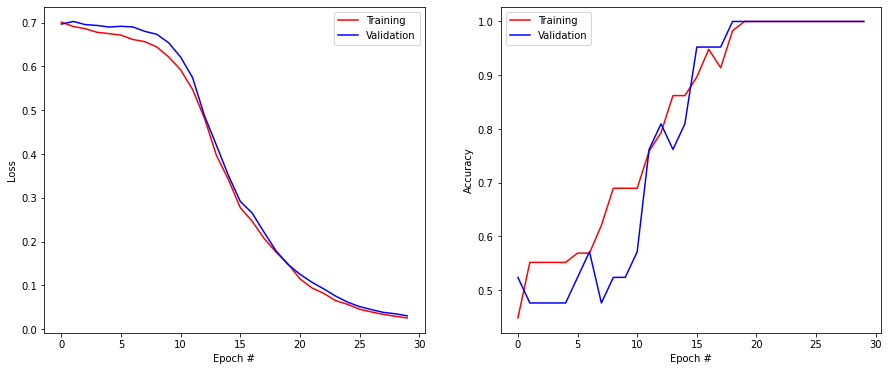

In [ ]:
model = small_model()

history = tf.keras.callbacks.History()

model.fit(X_train, T_train, validation_data=(X_test, T_test), epochs=30, batch_size=10, callbacks=[history])

score = model.evaluate(X_test, T_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

plt.figure(figsize=(15, 6))

plt.subplot(121)
plt.plot(history.history['loss'], '-r', label="Training")
plt.plot(history.history['val_loss'], '-b', label="Validation")
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(history.history['binary_accuracy'], '-r', label="Training")
plt.plot(history.history['val_binary_accuracy'], '-b', label="Validation")
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

**A:** It works easily.

**Q.** Once you have been able to successfully train the network, vary the different parts of the model to understand their influence: learning rate, number of units, optimizer, etc. Add another LSTM layer to see what happens. Exchange the LSTM layer with the GRU layer.

In [ ]:
def big_model():
    tf.keras.backend.clear_session()
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input((nb_words, len(vocabulary))))
    model.add(tf.keras.layers.LSTM(20, return_sequences=True))
    model.add(tf.keras.layers.LSTM(10, return_sequences=False))
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
    optimizer = tf.keras.optimizers.Adam(lr=0.01)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['binary_accuracy'])
    print(model.summary())
    return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 20)            3120      
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                1240      
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 4,371
Trainable params: 4,371
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
6/6 [==============================] - 3s 126ms/step - loss: 0.6949 - binary_accuracy: 0.6490 - val_loss: 0.7004 - val_binary_accuracy: 0.4762
Epoch 2/30
6/6 [==============================] - 0s 11ms/step - loss: 0.6915 - binary_accuracy: 0.5153 - val_loss: 0.6925 - val_binary_accuracy: 0.4762
Epoch 3/30
6/6 [==============================] - 0s 11ms/step - loss: 0

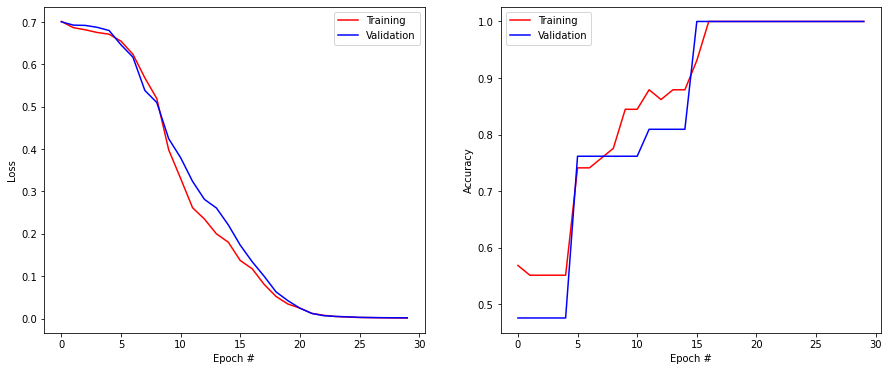

In [ ]:
model = big_model()

history = tf.keras.callbacks.History()

model.fit(X_train, T_train, validation_data=(X_test, T_test), epochs=30, batch_size=10, callbacks=[history])

score = model.evaluate(X_test, T_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

plt.figure(figsize=(15, 6))

plt.subplot(121)
plt.plot(history.history['loss'], '-r', label="Training")
plt.plot(history.history['val_loss'], '-b', label="Validation")
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(history.history['binary_accuracy'], '-r', label="Training")
plt.plot(history.history['val_binary_accuracy'], '-b', label="Validation")
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()

plt.show()